# Financial Econometrics 2 - Project 1
## Jan Kubal & Matyáš Mattanelli
### Instructions

**Part A)**

0) We ask you to create a folder for you project, in which you will be working on the project. You will be asked to send us this project that we can look at your progress and browse through your work. Please follow the instructions in the seminar or a documentation of julia about the activation of an environment and use it for your project. (It can be found also here: https://pkgdocs.julialang.org/v1/environments/ even it is from prompt/terminal, in a notebook use `Pkg.activate(".")`) 
* In your project, you will be adding packages, using them, you can create a script files as well and load them (with helper functions if needed.)


1) Use package `MarketData`, `Quandl`, or different one, if needed go to their github pages and `docs`, then **download data for an asset** of your choice.
2) Use plot to look at the data, do some summary statistics, `Statistics`, `DataFrames`, `StatsPlots` packages
3) Use GARCH to **model** asset data and **forecast**.
3) **Plot** forecasts.
    
This part is for you to get you familiar with julia, its syntax, and pacakges.

**Part B)**
- *OLS* vs *ML* estimation HAR
    - Estimate coefficients with different approaches
    - Optim.jl vs Flux.jl
    - Discuss coefficients, show them in scatter, histograms
    - test different activations in NN
    - play around with regularizations
    - Make Q-Q plots, a table of performance

**Part C)**
- Find a dataset or time-series and do the prediction task employing methods (not neccesarily all of them) we covered during lectures L1-L6 (next week)
    - It can be cross-sectional finance example
    - OR forecasting time-series (maybe preferably)
- Use ensemble technique/averaging in final predictions when use neural network models
- Use performance measures
- As an example, and also a wrap-up of NN techniques, you can consult different papers in the literature.
    - Papers on forecasting:
        - Babiak & Barunik (2020) contains NN section and uses Goyal & Welch in forecasting part [arxiv](https://arxiv.org/abs/2009.03394)
        - Feng et al. (2018) Deep Learning for Predicting Asset Returns (https://arxiv.org/pdf/1804.09314.pdf)    
    - Papers on distribution (both predict parameters of distribution):
        - Salinas et al. (2019): DeepAR [pdf](https://arxiv.org/pdf/1704.04110v3.pdf), [python](https://paperswithcode.com/paper/deepar-probabilistic-forecasting-with)
        - Weron et al. (2022): Distributional neural networks for electricity prices forecasting [arxiv pdf](https://arxiv.org/abs/2207.02832)
        - CHALLENGING - to replicate one of the two :) (definitely not necessary)

---

## Environment preparation

In [1]:
#Activate the environment
import Pkg
Pkg.activate(".")
Pkg.instantiate() #In case the environment is activated for the first time

  Activating project at `d:\Dokumenty\Vejška\Magisterské studium\Financial Econometrics 2\Project1\Financial-Econometrics-II`

#### Loading required packages

In [2]:
#Load required packages
import Dates
import MarketData
import Statistics
import Plots
import DataFrames
import StatsPlots
import StatsBase
import ARCHModels
import LinearAlgebra
import Optim
import Flux

include("utils.jl") #A file containing functions taken from the seminar + custom defined functions

[> Loaded d:\Dokumenty\Vejška\Magisterské studium\Financial Econometrics 2\Project1\Financial-Econometrics-II\utils.jl


## Part A)

### 1.

We have chosen the McDonald's stock price as the variable of interest. We will download it from Yahoo Finance. We acquire only 10 years worth of data (January 2012 - December 2021) since ancient history may not have relevance for the present, in fact, it may adversely affect the forecasts.

In [3]:
#Download data for McDonald's stock from Yahoo (42.2s)
t1 = Dates.DateTime(2012, 1, 1) #Starting period
t2 = Dates.DateTime(2022, 1, 1) #Ending period
MCD = MarketData.yahoo("MCD", MarketData.YahooOpt(period1 = t1, period2 = t2));

We are interested only in the adjusted close price so we will store it in a variable. We also calculate the log-returns since we do not expect the price to be stationary.

In [4]:
#Store only the Adjusted Close price
MCD_adj_close = MarketData.values(MCD[:AdjClose])

#Calculate log-returns
MCD_log_ret = diff(log.(MCD_adj_close));

### 2.

In this section we provide some fundamental summary statistics.

In [5]:
#Define function for summary statistics
n(x) = size(x)[1] #Define a function calculating the number of observations
quantile_5(x) = Statistics.quantile(x, 0.05) #Define a function calculating the 5th percentile
quantile_25(x) = Statistics.quantile(x, 0.25) #Define a function calculating the 25th percentile
quantile_75(x) = Statistics.quantile(x, 0.75) #Define a function calculating the 75th percentile
quantile_95(x) = Statistics.quantile(x, 0.95) #Define a function calculating the 95th percentile
sum_stats = [n, Statistics.mean, Statistics.std, quantile_5, quantile_25, Statistics.median, quantile_75, quantile_95, StatsBase.skewness, StatsBase.kurtosis] #Store the functions caclulating summary statistics into a vector for looping
str_info = ["Number of observations: ", "Mean: ", "Standard deviation: ", "5th percentile: ", "25th percentile: ", "Median: ", "75th percentile: ", "95th percentile: ", "Skewness: ", "Kurtosis: "] #Define strings to be printed

#Print summary statistics for raw price
println("Raw price")
for i in range(1, size(sum_stats)[1])
    println(str_info[i] * string(round(sum_stats[i](MCD_adj_close), digits = 2)))
end

#Print summary statistics for log-returns
println("")
println("Log-returns")
for i in range(1, size(sum_stats)[1])
    println(str_info[i] * string(round(sum_stats[i](MCD_log_ret), digits = 2)))
end


Raw price


Number of observations: 2517.0
Mean: 129.33
Standard deviation: 54.89


5th percentile: 68.85
25th percentile: 77.23
Median: 108.6
75th percentile: 175.74
95th percentile: 228.27
Skewness: 0.54
Kurtosis: -1.03

Log-returns
Number of observations: 2516.0
Mean: 0.0
Standard deviation: 0.01
5th percentile: -0.02
25th percentile: -0.0
Median: 0.0
75th percentile: 0.01
95th percentile: 0.02
Skewness: -0.19
Kurtosis: 37.56


The summary statistics suggest that the price is slightly positively skewed and platykurtic. On the other hand, the returns appear to be more symmetric (even though slightly negatively skewed) and with very heavy tails (high kurtosis). The average return is roughly zero (measured by both the mean and the median) so in general the distribution of the returns does not deviate from our expectations.

We can also plot the time series of the prices as well as returns. We can see that there is an obvious trend in price and as is common for asset prices, the time series is far from stationary.

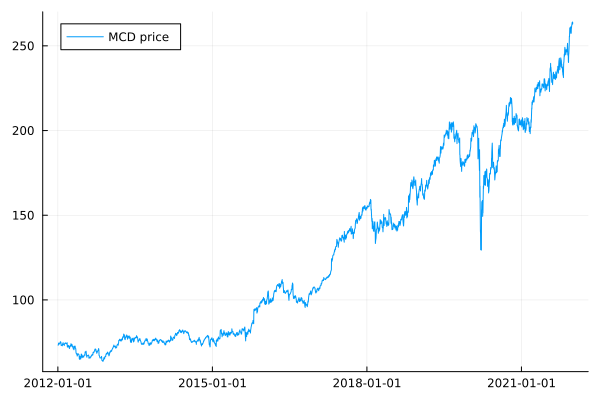

In [6]:
#Plotting the time series of price
Plots.plot(MCD[:AdjClose], labels = "MCD price", legend = :topleft)

On the other hand, the returns appear to be mean-stationary. However, we can observe some large variance clusters.

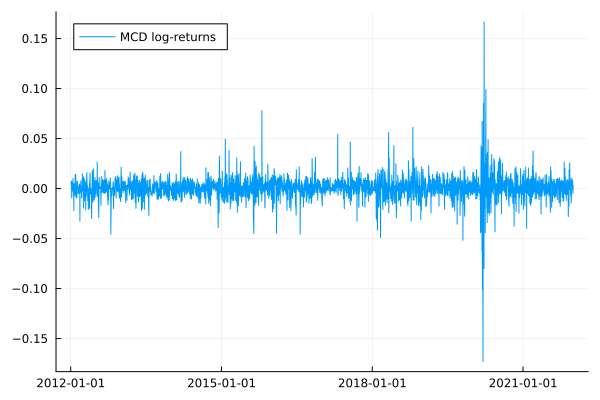

In [7]:
#Plotting the time series of log-returns
Plots.plot(MarketData.TimeArray(MarketData.timestamp(MCD)[2:end], MCD_log_ret), labels = "MCD log-returns", legend = :topleft)

The inspection of histogram may give an insight into the shape of a distribution of a variable. As we can see, the histogram of MCD price below indicates that the series is positively skewed. This corresponds to the positive skewness calculated in the summary statistics.

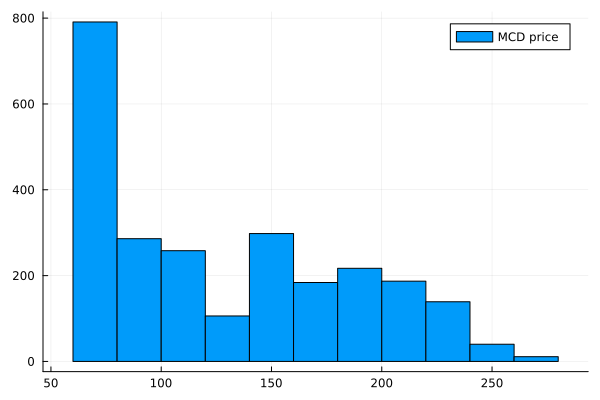

In [8]:
#Plot histogram of price
Plots.histogram(MCD[:AdjClose], labels = "MCD price")

On the other hand, the returns appear to be symmetric and with very heavy tails.

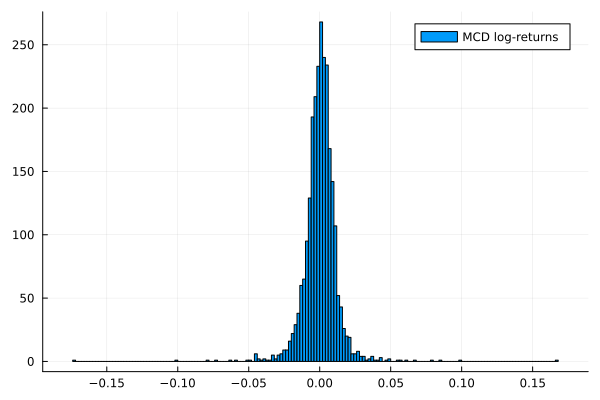

In [9]:
#Plot histogram of log-returns
Plots.histogram(MarketData.TimeArray(MarketData.timestamp(MCD)[2:end], MCD_log_ret), labels = "MCD log-returns")

#### 3. 

In this section we estimate a GARCH model using the returns on the MCD's asset. We use the ``ARCHModels`` package rather than ``GARCH`` due to the incompability of ``GARCH`` with ``Flux`` which is a package used in subsequent parts. Firstly, we will inspect the dependencies in the returns.

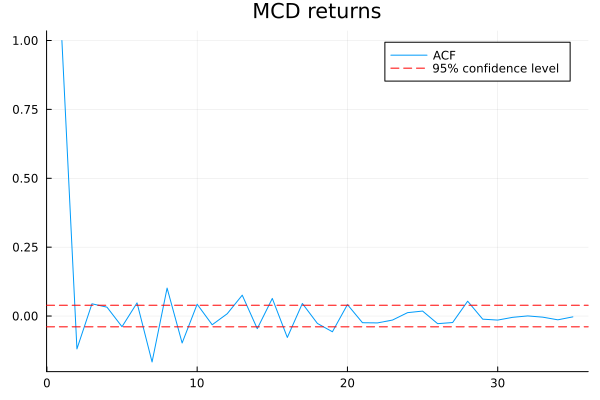

In [10]:
#Define a custom ACF plot function
function plot_ACF(time_series, title)
    Plots.plot(StatsBase.autocor(time_series), title = title, label = "ACF")
    Plots.hline!([1.96 / sqrt(length(time_series))], color = "red", linestyle = :dash, label = "95% confidence level")
    Plots.hline!([-1.96 / sqrt(length(time_series))], color = "red", linestyle = :dash, label = false)
end
#Plot ACF
plot_ACF(MCD_log_ret, "MCD returns")

As we can see, there appear to be some significant dependencies in the returns. Arguably, these could be modelled using purely GARCH but we will try an ARMA model first and see the results. We will start with a simple AR(1) model.

In [11]:
#Fit AR(1)
ar1 = ARCHModels.fit(ARCHModels.AR{1}, MCD_log_ret)


TGARCH{0, 0, 0} model with Gaussian errors, T=2516.

Mean equation parameters:
─────────────────────────────────────────────────
        Estimate    Std.Error   z value  Pr(>|z|)
─────────────────────────────────────────────────
c    0.000567895  0.000249483   2.27629    0.0228
φ₁  -0.11939      0.0537783    -2.22005    0.0264
─────────────────────────────────────────────────

Volatility parameters:
────────────────────────────────────────────
     Estimate   Std.Error  z value  Pr(>|z|)
────────────────────────────────────────────
ω  0.00014689  1.75786e-5  8.35618    <1e-16
────────────────────────────────────────────


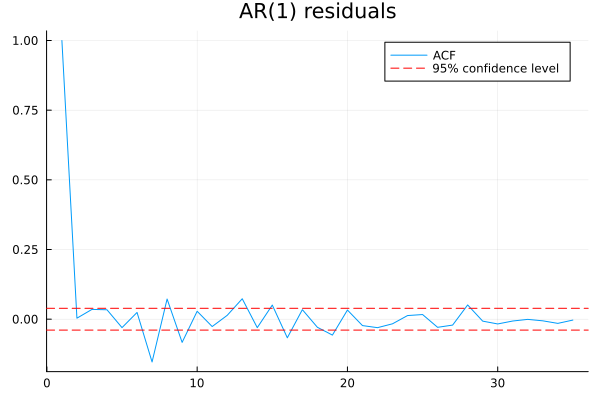

In [12]:
#Plot ACF of AR(1) residuals
plot_ACF(ARCHModels.residuals(ar1), "AR(1) residuals")

As can be seen, the coefficient of the first lag is significant and we have successfully modeled some dependencies. Nevertheless, there are still some significant dependecies left in the AR(1) residuals. Therefore, we will try estimating an ARMA(1,1) model.

In [13]:
#Fit ARMA(1,1)
arma11 = ARCHModels.fit(ARCHModels.ARMA{1,1}, MCD_log_ret)


TGARCH{0, 0, 0} model with Gaussian errors, T=2516.

Mean equation parameters:
─────────────────────────────────────────────────
        Estimate   Std.Error    z value  Pr(>|z|)
─────────────────────────────────────────────────
c    0.000636254  0.00028516   2.23122     0.0257
φ₁  -0.253833     0.261443    -0.970894    0.3316
θ₁   0.135424     0.254012     0.53314     0.5939
─────────────────────────────────────────────────

Volatility parameters:
─────────────────────────────────────────────
      Estimate   Std.Error  z value  Pr(>|z|)
─────────────────────────────────────────────
ω  0.000146814  1.74947e-5  8.39189    <1e-16
─────────────────────────────────────────────


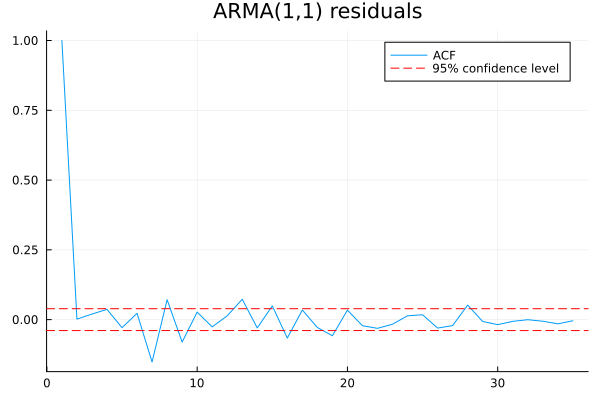

In [14]:
#Plot ACF of ARMA(1,1) residuals
plot_ACF(ARCHModels.residuals(arma11), "ARMA(1,1) residuals")

Since both the coefficients on AR(1) and MA(1) are insignificant and the improvement upon the AR(1) model is negligible, we will opt for the AR(1) model to avoid overfitting. We will hope to model the remaining dependencies using volatility modelling. Prior to estimating GARCH, we will verify the presence of ARCH effects using the LM test.

In [15]:
#Test for ARCH effects
ARCHModels.ARCHLMTest(ARCHModels.residuals(ar1), 7)

ARCH LM test for conditional heteroskedasticity
-----------------------------------------------
Population details:
    parameter of interest:   T⋅R² in auxiliary regression
    value under h_0:         0
    point estimate:          658.2

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-99

Details:
    sample size:                    2516
    number of lags:                 7
    LM statistic:                   658.2


The LM test confirms the presence of ARCH effects in the AR(1) residuals. Therefore, we will estimate a GARCH model in the next step. As is common, we choose the GARCH(1,1) specification since it is very often sufficient to model the volatility. In addition, given the shape of the histogram of the returns, we assume a *t*-distribution to accomodate the heavy tails.

In [16]:
#Estimating GARCH
spec = ARCHModels.GARCH{1, 1}([0, .1, .08]) #Define the specifications and choose intial values for the coefficients
MCD_garch = ARCHModels.UnivariateARCHModel(spec, MCD_log_ret; dist = ARCHModels.StdT(3.), meanspec = ARCHModels.AR{1}([0,-.1])) #Specify the model
ARCHModels.fit!(MCD_garch) #Fitting the model


GARCH{1, 1} model with Student's t errors, T=2516.

Mean equation parameters:
─────────────────────────────────────────────────
        Estimate    Std.Error   z value  Pr(>|z|)
─────────────────────────────────────────────────
c    0.000870849  0.000167954   5.18506    <1e-06
φ₁  -0.0470432    0.0198131    -2.37434    0.0176
─────────────────────────────────────────────────

Volatility parameters:
──────────────────────────────────────────────
      Estimate   Std.Error   z value  Pr(>|z|)
──────────────────────────────────────────────
ω   6.39591e-6  2.97084e-6   2.1529     0.0313
β₁  0.854374    0.0516745   16.5338     <1e-60
α₁  0.0908547   0.0305253    2.97638    0.0029
──────────────────────────────────────────────

Distribution parameters:
─────────────────────────────────────────
   Estimate  Std.Error  z value  Pr(>|z|)
─────────────────────────────────────────
ν   4.21026   0.363057  11.5967    <1e-30
─────────────────────────────────────────


As can be seen, all the estimated coefficients are statistically significant. We can asses whether we successfully modelled the dependencies by inspecting the ACF plot.

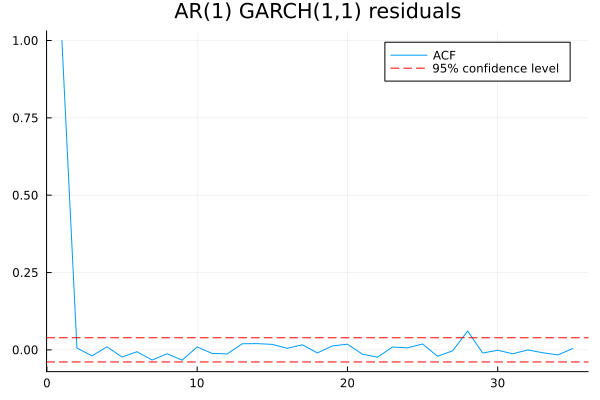

In [17]:
#Plot ACF for AR(1) GARCH(1,1) residuals
plot_ACF(ARCHModels.residuals(MCD_garch), "AR(1) GARCH(1,1) residuals")

The ACF plot suggests that the model residuals of the model suffer from virtually no dependencies. We can further verify this by performing the ARCH test.

In [18]:
#Test for ARCH effects
ARCHModels.ARCHLMTest(MCD_garch, 7)

ARCH LM test for conditional heteroskedasticity
-----------------------------------------------
Population details:
    parameter of interest:   T⋅R² in auxiliary regression
    value under h_0:         0
    point estimate:          0.966256

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.9954

Details:
    sample size:                    2516
    number of lags:                 7
    LM statistic:                   0.966256


The p-value of the LM test is very high suggesting that there are no significant ARCH effects in the model residuals.

#### 4.

Now that we seem to have a reliable model, we can make forecasts and plot them. We will start with the fitted volatility values.

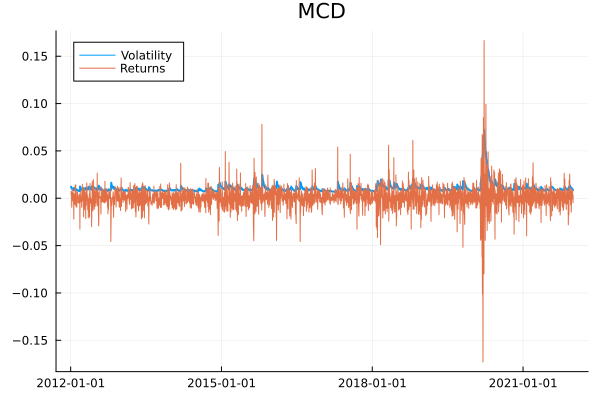

In [19]:
#Plot the fitted values
MCD_garch_vol = MarketData.TimeArray(MarketData.timestamp(MCD[2:end]), ARCHModels.volatilities(MCD_garch))
Plots.plot(MCD_garch_vol, title = "MCD", legend = :topleft, label = "Volatility", lw = 2)
Plots.plot!(MarketData.TimeArray(MarketData.timestamp(MCD[2:end]), MCD_log_ret), label = "Returns")


As can be seen, the model seems to at least partially capture some of the volatility clusters. In the next step we will perform out of sample forecasts using a rolling window.

In [20]:
#Making 1-step-ahead predictions on a rolling window
window_size = 500 #Specify the size of the rolling window
MCD_garch_vol_oot = Vector{Float64}(undef, length(MCD_log_ret) - window_size) #Initialize an empty vector for the forecasts
for i in 1:length(MCD_garch_vol_oot) #Loop through the rolling windows
    MCD_garch_rol = ARCHModels.UnivariateARCHModel(spec, MCD_log_ret[i:(window_size + i - 1)]; dist = ARCHModels.StdT(3.), meanspec = ARCHModels.AR{1}([0,-.1])) #Specify the model
    ARCHModels.fit!(MCD_garch) #Fit the model
    MCD_garch_vol_oot[i] = ARCHModels.predict(MCD_garch_rol)
end

Now we will compare the forecasted volatility with the fitted volatility.

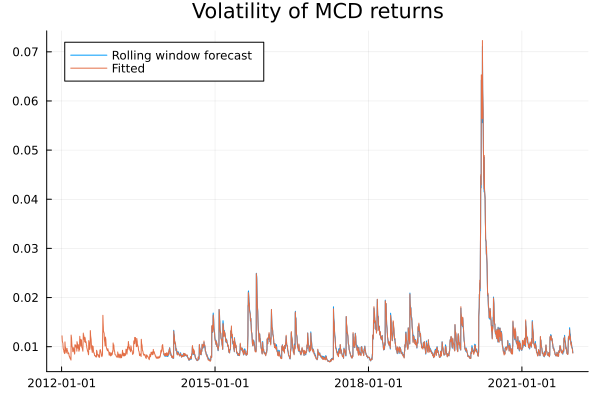

In [21]:
#Plot the predicted volatility vs. the fitted volatility
MCD_garch_vol_oot_timearray = MarketData.TimeArray(MarketData.timestamp(MCD_garch_vol[(window_size + 1):end]), MCD_garch_vol_oot) #Create a TimeArray from the volatility forecasts
Plots.plot(MCD_garch_vol_oot_timearray, title = "Volatility of MCD returns", label = "Rolling window forecast", legend = :topleft)
Plots.plot!(MCD_garch_vol, label = "Fitted")

As can be seen, there are some differences but the values are very similar. We can inspect the deviations further by plotting the difference of the two series.

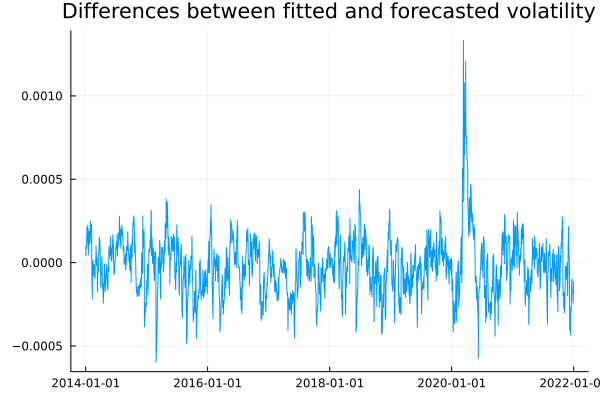

In [22]:
#Plot differences between fitted and forecasted volatility
Plots.plot(MCD_garch_vol[(window_size + 1):end] .- MCD_garch_vol_oot_timearray, title = "Differences between fitted and forecasted volatility", legend = false)

Even though the differences are very small, it appears that the fitted volatility is generally larger. We can also see that the greatest differences are in the first quarter of 2020 which may be associated with the coronavirus outbreak.

---

## Part B)

In this part we estimate the HAR model on our data using various methods and then compare the results. We start by computing Realized Variance: $RV_t = r^2_t$

In [23]:
#Calcualate RV 
target = MCD_log_ret.^2;

Next, we calculate the predictors for the HAR-RV model:

* Daily: $RV_{d_t} = RV_t$
* Weekly: $RV_{w_t} = \frac{1}{5}\sum_{i=0}^4RV_{t-i}$
* Monthly: $RV_{m_t} = \frac{1}{22}\sum_{i=0}^{22}RV_{t-i}$

As a target shall be used $RV_{t+1}$. Data are then split to train and test set. The former will be use for model development and the latter for evaluation. In addition, we standardize both sets using the mean and standard deviation of the training part to aid optimization.

*Note: `HAR_regressors()` taken from Seminar 3*

In [24]:
#Compute HAR regressors
predictors = HAR_regressors(target)

#Shift the target
target = target[23:end];

In [25]:
#Split into training and testing
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size)

#Standardization
mean_X_train = mapslices(StatsBase.mean, X_train; dims = 2) #Save the mean
std_X_train = mapslices(StatsBase.std, X_train; dims = 2) #Save the standard deviation
function standardize(data) #Define a function normalizing data based on mean and std of the training set
    data1 = copy(data) #Make a copy of the argument to prevent the function from changing it in place
    for i in 1:length(mean_X_train) #Loop through the rows and normalize them
        data1[i,:] = (data1[i,:] .- mean_X_train[i]) / std_X_train[i]
    end
    return data1
end
X_train = standardize(X_train) #Standardize the training set
X_test = standardize(X_test); #Standardize the testing set

Firstly, we will estimate the HAR coefficients using OLS. We define a loss function and find the minimum using gradient descent.

In [26]:
#OLS via Optim
function loss_HAR((beta_0, beta_1, beta_2, beta_3)) #Define the loss function for HAR
    return StatsBase.mean((beta_0 .+ beta_1 * X_train[1, :] + beta_2 * X_train[2, :] + beta_3 * X_train[3, :] - transpose(y_train)) .^2)
end
OLS_optim = Optim.optimize(loss_HAR, [1., 1., 1., 1.], Optim.GradientDescent()) #Optimize the loss
OLS_optim.minimizer

4-element Vector{Float64}:
 9.582972934793564e-5
 5.748576984133633e-6
 1.4315005573496852e-5
 1.0534649901196286e-5

We can compare the results of optimization with the analytical solution. As can be seen, the coefficients are virtually identical.

In [27]:
#Analytical OLS solution
X_train_with_int = [ones((1, size(X_train)[2])); X_train] #Add ones for intercept estimation
inv(X_train_with_int * transpose(X_train_with_int)) * X_train_with_int * transpose(y_train) #Calculate the coefficients

4×1 Matrix{Float64}:
 9.582972934729498e-5
 5.745733397304595e-6
 1.4322353703654352e-5
 1.053107552515593e-5

Now that we have the coefficients, we can calculate the Mean Squared Error on the training and test sets.

In [28]:
#Calculating Mean Squared Error
function calc_fitted(coefs, data)
    return coefs[1] .+ coefs[2] * data[1, :] + coefs[3] * data[2, :] + coefs[4] * data[3, :]
end
function MSE(fitted, actual)
    return StatsBase.mean((fitted - actual) .^ 2)
end
println("OLS train MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_train), transpose(y_train))))
println("OLS test MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_test), transpose(y_test))))

OLS train MSE: 7.649704387546445e-8
OLS test MSE: 3.7976367770936892e-6


As expected, the MSE is higher for the test set. As required, we also provide a QQ-plot of the residuals.

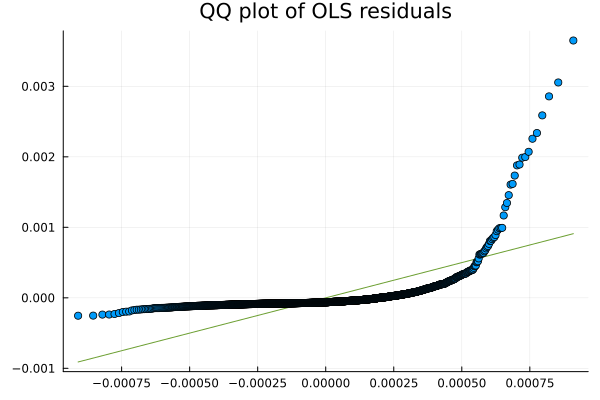

In [29]:
#QQ plot of OLS residuals
OLS_resid = transpose(y_train)[:,1] - calc_fitted(OLS_optim.minimizer, X_train)
StatsPlots.qqnorm(OLS_resid, title = "QQ plot of OLS residuals")

As the QQ plot shows, the distribution of the residuals from the HAR regression is very far from normal.

 Next, we will estimate a neural network with no hidden layer and the inputs being the HAR regressors. This should be equivalent to estimating a linear regression.

In [48]:
#NN estimation
model = Flux.Dense(3 => 1) #Define the specification
loss_HAR_NN(x, y) = Flux.Losses.mse(model(x), y) #Define the loss function
opt = Flux.Descent() #Specify the optimizer as gradient Descent
parameters = Flux.params(model) #Save the parameters to be estimated
data_train = [(X_train, y_train)] #Specify the training data
for epoch in 1:300 #Train the model iteratively
    Flux.train!(loss_HAR_NN, parameters, data_train, opt) #Train
    epoch % 20 == 0 ? println("Epoch $epoch \t MSE (train): ", loss_HAR_NN(X_train, y_train), " \t MSE (test): ", loss_HAR_NN(X_test, y_test)) : nothing #Report the losses for each 20 epochs
end

Epoch 20 	 MSE (train): 0.019881237 	 MSE (test): 1.1946632
Epoch 40 	 MSE (train): 0.0007006797 	 MSE (test): 0.047866043
Epoch 60 	 MSE (train): 2.526883e-5 	 MSE (test): 0.0017771001
Epoch 80 	 MSE (train): 9.830682e-7 	 MSE (test): 6.957986e-5
Epoch 100 	 MSE (train): 1.0912187e-7 	 MSE (test): 6.481816e-6
Epoch 120 	 MSE (train): 7.767111e-8 	 MSE (test): 3.9539236e-6
Epoch 140 	 MSE (train): 7.65393e-8 	 MSE (test): 3.81456e-6
Epoch 160 	 MSE (train): 7.649856e-8 	 MSE (test): 3.800367e-6
Epoch 180 	 MSE (train): 7.6497095e-8 	 MSE (test): 3.7981154e-6
Epoch 200 	 MSE (train): 7.6497045e-8 	 MSE (test): 3.7977043e-6
Epoch 220 	 MSE (train): 7.6497045e-8 	 MSE (test): 3.7976272e-6
Epoch 240 	 MSE (train): 7.649704e-8 	 MSE (test): 3.7976122e-6
Epoch 260 	 MSE (train): 7.649704e-8 	 MSE (test): 3.7976097e-6
Epoch 280 	 MSE (train): 7.649704e-8 	 MSE (test): 3.797609e-6
Epoch 300 	 MSE (train): 7.6497045e-8 	 MSE (test): 3.797609e-6


As can be seen, not only the MSE decreases with each 20 epochs but for the last 40 epochs it no longer further decreases which suggests that the optimization converged. We can now compare the MSEs with the values obtained via OLS.

In [31]:
#Compare the losses of OLS and ML
println("OLS train MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_train), transpose(y_train))))
println("OLS test MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_test), transpose(y_test))))
println("ML train MSE: " * string(loss_HAR_NN(X_train, y_train)))
println("ML test MSE: " * string(loss_HAR_NN(X_test, y_test)))

OLS train MSE: 7.649704387546445e-8
OLS test MSE: 3.7976367770936892e-6
ML train MSE: 7.649703e-8
ML test MSE: 3.797609e-6


The values are virtually the same. The same should apply to the estimated coefficients:

In [32]:
#Compare coefficients of OLS and ML
[OLS_optim.minimizer [model.bias; model.weight[1,:]]]

4×2 Matrix{Float64}:
 9.58297e-5  9.58297e-5
 5.74858e-6  5.74573e-6
 1.4315e-5   1.43224e-5
 1.05346e-5  1.05311e-5

In the next step we will attempt to train a more sophisticated neural network to see if we can achieve a lower loss. For this purpose we will define a generic function.

In [49]:
size(X_train, 1)

3

In [33]:
#Define a function for Neural Network estimation. We assume only a single hidden layer since it should be sufficient for approximation of any function
function train_NN(X_train, y_train, X_test, y_test; dropout = false, nodes = 5, activ_func = Flux.relu, output_func = Flux.identity, loss_func = Flux.Losses.mse, α = 0, return_inits = true, learn_rate = 0.001, opt = Flux.Descent(learn_rate), batch_size = false, n_epochs = 200)
    if dropout == false
        model = Flux.Chain(Flux.Dense(size(X_train, 1), nodes, activ_func), Flux.Dense(nodes, size(y_train, 1), output_func)) #Specify the model
    else
        model = Flux.Chain(Flux.Dense(size(X_train, 1), nodes, activ_func), Flux.Dropout(dropout), Flux.Dense(nodes, size(y_train, 1), output_func)) #Specify the model
    end
    l2_norm(x) = sum(abs2, x) #Define a function to calculate the L2 norm
    loss(x, y) = loss_func(model(x), y) + α*sum(l2_norm, Flux.params(model)) #Specify the loss function with an L2 regularization term (defaultly, regularization is disabled by setting α = 0)
    parameters = Flux.params(model) #Specify the parameters to be estimated
    if return_inits #If required, save the initial parameters
        initial_parameters = extract_params(model)
    end
    if batch_size == false #In case all observations are to be used for each epoch
        data_train = [(X_train, y_train)]
    else
        data_train = Flux.DataLoader((X_train, y_train), batchsize = batch_size) #Dissect the training data into mini-batches
    end
    for epoch in 1:n_epochs #Train the model iteratively
        previous_loss = loss_func(model(X_train), y_train) #Store the loss based on the weights from the previous iteration
        Flux.train!(loss, parameters, data_train, opt) #Train the model for the current epoch
        current_loss = loss_func(model(X_train), y_train) #Store the new loss
        if previous_loss == current_loss #Define a condition that stops the training upon convergence
            println("Converged at epoch $epoch \t MSE (train): ", current_loss, " \t MSE (test): ", loss_func(model(X_test), y_test))
            break
        else
            epoch % (n_epochs / 10) == 0 ? println("Epoch $epoch \t MSE (train): ", current_loss, " \t MSE (test): ", loss_func(model(X_test), y_test)) : nothing #Report the losses for each tenth of the number of epochs
        end
    end
    if return_inits #If required, return the initial parameters
        return initial_parameters, model
    else #Otherwise return only the trained model
        return model
    end
end;

We will start by training a neural network with 3 hidden nodes and a ReLU activation function. We will use Gradient Descent for optimization.

In [78]:
#Train a neural network with 3 hidden nodes
NN_3_inits, NN_3 = train_NN(X_train, y_train, X_test, y_test; nodes = 3, n_epochs = 1000, learn_rate = 0.1);

Epoch 100 	 MSE (train): 5.0650524e-6 	 MSE (test): 0.00018202678
Epoch 200 	 MSE (train): 1.7028556e-6 	 MSE (test): 1.2516488e-5


Epoch 300 	 MSE (train): 6.35762e-7 	 MSE (test): 7.304824e-6
Epoch 400 	 MSE (train): 2.6878052e-7 	 MSE (test): 5.476941e-6


Epoch 500 	 MSE (train): 1.4249277e-7 	 MSE (test): 4.7374715e-6
Epoch 600 	 MSE (train): 9.902244e-8 	 MSE (test): 4.415175e-6


Epoch 700 	 MSE (train): 8.406005e-8 	 MSE (test): 4.26435e-6
Epoch 800 	 MSE (train): 7.8909714e-8 	 MSE (test): 4.1894905e-6


Epoch 900 	 MSE (train): 7.713599e-8 	 MSE (test): 4.148724e-6
Epoch 1000 	 MSE (train): 7.652518e-8 	 MSE (test): 4.1289204e-6


After trying different learning rates and number of epochs, the model succesfully converged. We can compare the losses with the previous models.

In [79]:
#Compare losses
println("OLS train MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_train), transpose(y_train))))
println("OLS test MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_test), transpose(y_test))))
println("ML train MSE: " * string(loss_HAR_NN(X_train, y_train)))
println("ML test MSE: " * string(loss_HAR_NN(X_test, y_test)))
println("NN (3 nodes) train MSE: " * string(Flux.Losses.mse(NN_3(X_train), y_train)))
println("NN (3 nodes) test MSE: " * string(Flux.Losses.mse(NN_3(X_test), y_test)))

OLS train MSE: 7.649704387546445e-8
OLS test MSE: 3.7976367770936892e-6
ML train MSE: 7.6497045e-8
ML test MSE: 3.797609e-6
NN (3 nodes) train MSE: 7.652518e-8
NN (3 nodes) test MSE: 4.1289204e-6


As we can see, the simpler models appear to outperform the more complex neural network. This may be a sign of overfitting. Before trying different parameter settings, we will compare the initial coefficients of the neural networks with their optimized counterparts.

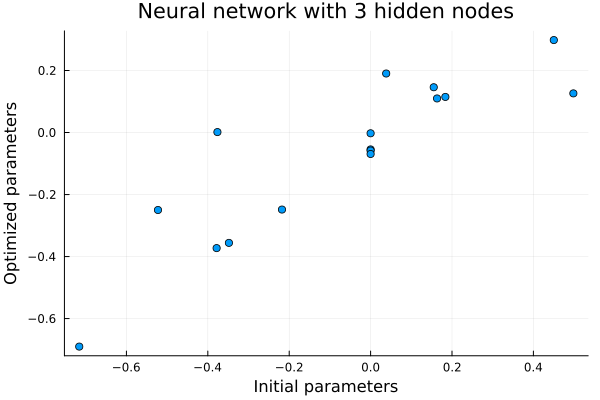

In [36]:
#Plot scatter of coefficients
Plots.scatter(NN_3_inits, extract_params(NN_3), legend = false, title = "Neural network with 3 hidden nodes", xlab = "Initial parameters", ylab = "Optimized parameters")

The scatter plot indicates that there is a clear linear relationship between the initial and optimized coefficients. This suggests that the initial values were not unreasonable. We will provide a histogram of the coefficients as well.

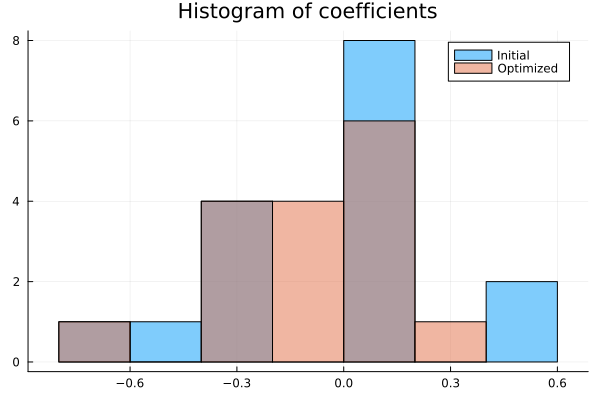

In [37]:
#Histogram of coefficients
Plots.histogram(NN_3_inits, title = "Histogram of coefficients", label = "Initial", bins = 8, fillalpha = 0.5)
Plots.histogram!(extract_params(NN_3), label = "Optimized", bins = 8, fillalpha = 0.5)

Similarly to to the scatter plot, the histograms shows that the distribution of the coefficients appear to be very similar. Nevertheless, we have estimated only 16 coefficients which seems to be an insufficient amount of observations to estimate the shape of a distribution. 

Since our model might be subjected to overfitting, we will try to regularize the parameters using L2 regularization. We will do so by specifying the parameter $\alpha$ which represents the sensitivity to the size of the parameters.

In [38]:
#Train a neural network with 3 hidden nodes and L2 regularization
NN_3_L2 = train_NN(X_train, y_train, X_test, y_test; nodes = 3, n_epochs = 1000, learn_rate = 0.1, α = 0.1, return_inits = false);

Epoch 100 	 MSE (train): 6.2241843e-6 	 MSE (test): 0.0002851832


Epoch 200 	 MSE (train): 8.0638486e-8 	 MSE (test): 4.390945e-6
Epoch 300 	 MSE (train): 7.721676e-8 	 MSE (test): 4.1400813e-6


Epoch 400 	 MSE (train): 7.7188254e-8 	 MSE (test): 4.1371054e-6
Converged at epoch 421 	 MSE (train): 7.718797e-8 	 MSE (test): 4.1370754e-6


In [39]:
#Compare losses
println("OLS train MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_train), transpose(y_train))))
println("OLS test MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_test), transpose(y_test))))
println("NN (3 nodes) train MSE: " * string(Flux.Losses.mse(NN_3_L2(X_train), y_train)))
println("NN (3 nodes) test MSE: " * string(Flux.Losses.mse(NN_3_L2(X_test), y_test)))

OLS train MSE: 7.649704387546445e-8
OLS test MSE: 3.7976367770936892e-6
NN (3 nodes) train MSE: 7.718797e-8
NN (3 nodes) test MSE: 4.1370754e-6


Utilizing L2 regularization results in a much faster and reliable convergence. Nevertheless, we still were not able to surpass the test MSE of a simple OLS model. As an another means of regularization we can use dropout.

In [40]:
#Train a neural network with 3 hidden nodes and dropout
NN_3_dropout = train_NN(X_train, y_train, X_test, y_test; nodes = 3, n_epochs = 1000, learn_rate = 0.1, dropout = 0.2, return_inits = false);

Epoch 100 	 MSE (train): 0.00019344201 	 MSE (test): 0.0007668676
Epoch 200 	 MSE (train): 3.489556e-5 	 MSE (test): 6.162608e-5


Epoch 300 	 MSE (train): 1.4331852e-5 	 MSE (test): 9.2417085e-6
Epoch 400 	 MSE (train): 8.1009475e-6 	 MSE (test): 8.419616e-6


Epoch 500 	 MSE (train): 5.2194055e-6 	 MSE (test): 5.946807e-6
Epoch 600 	 MSE (train): 3.684057e-6 	 MSE (test): 5.1638453e-6


Epoch 700 	 MSE (train): 2.7360004e-6 	 MSE (test): 5.121013e-6


Epoch 800 	 MSE (train): 2.1122728e-6 	 MSE (test): 6.1132196e-6


Epoch 900 	 MSE (train): 1.6858776e-6 	 MSE (test): 5.4669667e-6


Epoch 1000 	 MSE (train): 1.3699928e-6 	 MSE (test): 5.6625827e-6


The dropout regularization does not seem to help. This is in fact reasonable because we have a quite small network. So far we have been using the gradient descent optimizer. In the next step we will try Adam to see if it can secure better optimization.

In [41]:
#Train a neural network with 3 hidden nodes and Adam optimizer
NN_3_Adam = train_NN(X_train, y_train, X_test, y_test; nodes = 3, n_epochs = 1000, learn_rate = 0.1, opt = Flux.Adam(0.1), return_inits = false);

Epoch 100 	 MSE (train): 4.4861983e-7 	 MSE (test): 5.3555923e-5
Epoch 200 	 MSE (train): 7.967644e-8 	 MSE (test): 5.0326144e-6


Epoch 300 	 MSE (train): 7.7040234e-8 	 MSE (test): 4.1714043e-6
Converged at epoch 322 	 MSE (train): 7.703892e-8 	 MSE (test): 4.165322e-6


It seems that the Adam optimizer does not help. In terms of test MSE, the neural network has not provided a significant improvement so far. We can try to increase the number of nodes.

In [42]:
#Train a neural network with 7 hidden nodes
NN_7 = train_NN(X_train, y_train, X_test, y_test; nodes = 7, n_epochs = 1000, learn_rate = 0.01, return_inits = false, α=1);

Epoch 100 	 MSE (train): 4.39732e-5 	 MSE (test): 0.007208184
Epoch 200 	 MSE (train): 8.9762004e-8 	 MSE (test): 7.327541e-6


Epoch 300 	 MSE (train): 7.921974e-8 	 MSE (test): 4.178416e-6
Epoch 400 	 MSE (train): 7.940321e-8 	 MSE (test): 4.1608328e-6


Converged at epoch 475 	 MSE (train): 7.940743e-8 	 MSE (test): 4.1605513e-6


Not even the increase in the number of nodes seems to provide a significant improvement. The last thing we try is a different activation function. Even though ReLu should be the best choice given its simple gradient and also its ability to capture non-linearities, we will try *tanh* as well.

In [87]:
#Train a neural network with 3 hidden nodes and tanh activation function
NN_3_tanh = train_NN(X_train, y_train, X_test, y_test; nodes = 3, n_epochs = 1000, learn_rate = 0.5, activ_func = Flux.tanh, return_inits = false);

Epoch 100 	 MSE (train): 6.8236586e-5 	 MSE (test): 9.878e-5


Epoch 200 	 MSE (train): 2.3353366e-5 	 MSE (test): 3.7261354e-5


Epoch 300 	 MSE (train): 1.0580945e-5 	 MSE (test): 1.938262e-5
Epoch 400 	 MSE (train): 5.632582e-6 	 MSE (test): 1.2413425e-5


Epoch 500 	 MSE (train): 3.3954416e-6 	 MSE (test): 9.176813e-6
Epoch 600 	 MSE (train): 2.2646627e-6 	 MSE (test): 7.473831e-6


Epoch 700 	 MSE (train): 1.6420946e-6 	 MSE (test): 6.49416e-6
Epoch 800 	 MSE (train): 1.2738049e-6 	 MSE (test): 

5.8913283e-6
Epoch 900 	 MSE (train): 1.0407849e-6 	 MSE (test): 5.4992797e-6
Epoch 1000 	 MSE (train): 8.831621e-7 	 MSE (test): 5.2315577e-6


As can be seen, using *tanh* turned out to be a good idea. Nevertheless, we still were not able to beat the test MSE of the OLS regression. This is in fact in line with the literature which shows that it is very difficult if not close to impossible to beat HAR.

In the following table we provide a comparison of performance of different neural networks based on different hyperparameters.

In [90]:
#Table of MSEs
MSEs = [Flux.Losses.mse(model(X_test), y_test) for model in [NN_3, NN_3_L2, NN_3_dropout, NN_3_Adam, NN_7, NN_3_tanh]]
DataFrames.DataFrame(Number_of_nodes = vcat(fill(3, 4), 7, 3), Number_of_epochs = fill(1000, 6), Learning_rate = vcat(fill(0.1, 4), 0.01,0.5), L2_alpha = vcat(0, 0.1, fill(0, 4)), Dropout = vcat(0,0,0.2,fill(0, 3)), Optimizer = vcat(fill("Gradient Descent", 3), "Adam", fill("Gradient Descent", 2)), Activation_function = vcat(fill("ReLU", 5), "tanh"), MSE = MSEs)

Row,Number_of_nodes,Number_of_epochs,Learning_rate,L2_alpha,Dropout,Optimizer,Activation_function,MSE
,Int64,Int64,Float64,Float64,Float64,String,String,Float32
1,3,1000,0.1,0.0,0.0,Gradient Descent,ReLU,4.12892e-6
2,3,1000,0.1,0.1,0.0,Gradient Descent,ReLU,4.13708e-6
3,3,1000,0.1,0.0,0.2,Gradient Descent,ReLU,5.66258e-6
4,3,1000,0.1,0.0,0.0,Adam,ReLU,4.16532e-6
5,7,1000,0.01,0.0,0.0,Gradient Descent,ReLU,4.16055e-6
6,3,1000,0.5,0.0,0.0,Gradient Descent,tanh,5.23156e-6


---

# Part C)

In [ ]:
##ensemble averaging for a set of NN models

In [398]:
function get_ensemble(X_train, y_train, X_test, y_test, models; weights = false, loss = Flux.Losses.mse)
   
   fitted_ensemble = Matrix{Float64}(undef, 1, length(y_train)) #initialize empty matrices for ensembled values
   preds_ensemble = Matrix{Float64}(undef, 1, length(y_test))

   if weights == false #get weights of each model to be averaged
      weights = ones(length(models)) ./length(models) #if no weights given, produce simple average (same weights for all)
   else  
      weights = weights ./sum(weights) #(transform vector of weights such that it sums to 1)
   end

   i = 1
   for NN in models #for each model, get fitted/predicted values, multiply by weight and add them to the ensemble
      fitted_ensemble = fitted_ensemble .+ (NN(X_train)) .*weights[i]
      preds_ensemble = preds_ensemble .+ (NN(X_test)) .*weights[i]
      i +=1
   end      

   println("Score of the ensemble:")
   println("MSE (train): ", loss(fitted_ensemble, y_train), " \t MSE (test): ", loss(preds_ensemble, y_test))
   return [fitted_ensemble, preds_ensemble]
end;

In [474]:
ensemble_test = get_ensemble(X_train, y_train, X_test, y_test, [NN_3, NN_3_L2, NN_7], weights = [1,5,10]);

Score of the ensemble:
MSE (train): 2.1964742109460294e-6 	 MSE (test): 4.359282533623995e-6
